In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import TextVectorization
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['font.size'] = 18 

## Load, Visualize and Prepare Data

In [ ]:
import os

# Download McDonalds dataset
if not os.path.exists('mcdonalds-store-reviews.zip'):
    print("Downloading McDonalds dataset...")
    !kaggle datasets download -d nelgiriyewithana/mcdonalds-store-reviews
if os.path.exists('mcdonalds-store-reviews.zip'):
    print("Unzipping McDonalds dataset...")
    !unzip -n mcdonalds-store-reviews.zip

# Download IMDB dataset
if not os.path.exists('imdb-dataset-of-50k-movie-reviews.zip'):
    print("Downloading IMDB dataset...")
    !kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
if os.path.exists('imdb-dataset-of-50k-movie-reviews.zip'):
    print("Unzipping IMDB dataset...")
    !unzip -n imdb-dataset-of-50k-movie-reviews.zip


In [50]:
df_mc = pd.read_csv('McDonald_s_Reviews.csv', encoding="latin-1")
df_imdb = pd.read_csv('IMDB Dataset.csv')

In [51]:
df_mc.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [52]:
df_imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Converting McDonalds review labels from categorical to binary

In [53]:
df_mc = df_mc[df_mc['rating'] != '3 stars']
rating_mapping_mc = {
    '1 star': 0,
    '2 stars': 0,
    '4 stars': 1,
    '5 stars': 1
}

label_mc = df_mc['rating'].map(rating_mapping_mc).to_numpy()
print(label_mc[:10])
print(f'Labels McDonalds: {len(label_mc)}')

[0 1 0 1 0 0 0 0 0 1]
Labels McDonalds: 28578


### Converting IMDB review labels from categorical to binary 

In [54]:
label_imdb = df_imdb['sentiment'].map({'positive': 1, 'negative': 0}).to_numpy()
print(label_imdb[:10])
print(f'Labels IMDB: {len(label_imdb)}')

[1 1 1 0 1 1 1 0 0 1]
Labels IMDB: 50000


### Merging the data

In [55]:
data_mc = df_mc['review'].to_numpy()
data_imdb = df_imdb['review'].to_numpy()
data = np.append(data_imdb, data_mc)
label = np.append(label_imdb, label_mc)
print(f'Reviews: {len(data)}')
print(f'Labels: {len(label)}')

Reviews: 78578
Labels: 78578


### Visualize data distribution 

In [56]:
px.bar(x=['positive', 'negative'], y=[len(label[label == 1]), len(label[label == 0])], title='Overall review distribution')

In [57]:
px.bar(x=['positive', 'negative'], y=[len(label_mc[label_mc == 1]), len(label_mc[label_mc == 0])], title='McDonalds review distribution')

In [58]:
px.bar(x=['positive', 'negative'], y=[len(label_imdb[label_imdb == 1]), len(label_imdb[label_imdb == 0])], title='IMDB review distribution')

### Some Word Clouds

### Split data into train/validation/test sets

In [59]:
train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.2, random_state=42)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(62862,)
(62862,)
(15716,)
(15716,)


## Tokenization / Vectorization / Word Embedding

In [83]:
# Hyperparameters
MAX_FEATURES = 30000 
SEQ_LENGTH = 200
EMBEDDING_DIM = 16 
BATCH_SIZE = 128
NUM_EPOCHS = 20 

In [61]:
text_vectorizer = TextVectorization(max_tokens=MAX_FEATURES, output_sequence_length=SEQ_LENGTH)
text_vectorizer.adapt(train_data)
text_vectorizer.adapt(test_data)

# Check the vocabulary
vocabulary = text_vectorizer.get_vocabulary()
vocab_size = len(vocabulary)
print(f'Vocabulary size: {len(vocabulary)}')
print(f'First 10 Vocabulary Item: {vocabulary[:10]}')

# TODO We already have some bs in this vocabulary if we don't enforce the max_features => need better cleaning
print(f'Last 10 Vocabulary Item: {vocabulary[-10:]}')

Vocabulary size: 30000
First 10 Vocabulary Item: ['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'i']
Last 10 Vocabulary Item: ['sinisterbr', 'singnative', 'singersongwriter', 'singerbr', 'singbr', 'sineater', 'sinbr', 'simulation', 'simulating', 'simplifying']


### Encode Reviews to SEQ_LENGTH words (padded)

In [62]:
train_data = text_vectorizer(train_data)
test_data = text_vectorizer(test_data)

print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Train data shape: (62862, 200)
Test data shape: (15716, 200)


## Defining the Model

Since we only want to classify our reviews into either positive or negative sentiment, we don't need to use the full transformer architecture. The encoder block is sufficient. Via. [Attention is all you need](https://arxiv.org/abs/1706.03762).

In [63]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [77]:
# Model Hyperparameters
NUM_HEADS = 8  # number of attention heads
FFN_DIM = 1024 # hidden layer size in feed forward network inside transformer
HEAD_DIM = 64 # hidden layer size in classification head
DROPOUT = 0.3

In [85]:
def create_model():
    inputs = layers.Input(shape=(SEQ_LENGTH,))
    embedding_layer = TokenAndPositionEmbedding(SEQ_LENGTH, MAX_FEATURES, EMBEDDING_DIM)
    x = embedding_layer(inputs)
    transformer_block = TransformerEncoder(EMBEDDING_DIM, NUM_HEADS, FFN_DIM)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(DROPOUT)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(DROPOUT)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [86]:
transformer_model = create_model()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 16)          483200    
 g_4 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_encoder_4 (Tran  (None, 200, 16)          42464     
 sformerEncoder)                                                 
                                                                 
 global_average_pooling1d_4   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_18 (Dropout)        (None, 16)                0   

## Training the Model

### Defining some callbacks for better control of model training

In [87]:
model_name = 'transformer_model.h5' 
checkpoint = keras.callbacks.ModelCheckpoint(
    model_name,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

learning_rate_decay = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.2,
    min_lr=0.00001,
    verbose=1
)  

callbacks = [checkpoint, early_stopping]

In [88]:
history = transformer_model.fit(
    train_data,
    train_label,    
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/20
393/393 [==============================] - ETA: 0s - loss: 0.4552 - accuracy: 0.7735
Epoch 1: val_loss improved from inf to 0.31514, saving model to transformer_model.h5
393/393 [==============================] - 27s 64ms/step - loss: 0.4552 - accuracy: 0.7735 - val_loss: 0.3151 - val_accuracy: 0.8702
Epoch 2/20
389/393 [============================>.] - ETA: 0s - loss: 0.2598 - accuracy: 0.8987
Epoch 2: val_loss improved from 0.31514 to 0.31362, saving model to transformer_model.h5
393/393 [==============================] - 16s 41ms/step - loss: 0.2595 - accuracy: 0.8988 - val_loss: 0.3136 - val_accuracy: 0.8811
Epoch 3/20
393/393 [==============================] - ETA: 0s - loss: 0.1971 - accuracy: 0.9272
Epoch 3: val_loss did not improve from 0.31362
393/393 [==============================] - 12s 31ms/step - loss: 0.1971 - accuracy: 0.9272 - val_loss: 0.3412 - val_accuracy: 0.8827
Epoch 4/20
392/393 [============================>.] - ETA: 0s - loss: 0.1603 - accuracy: 0.9

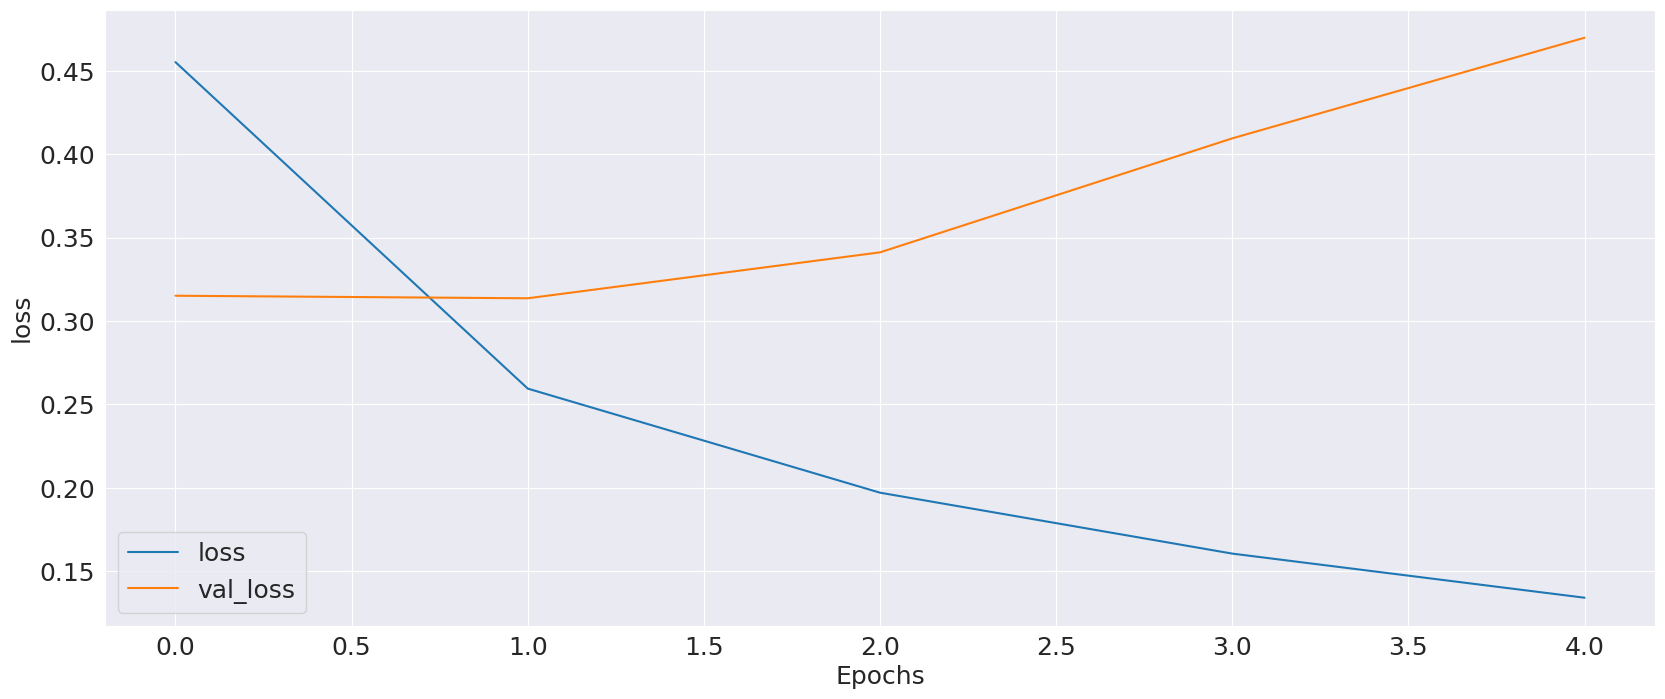

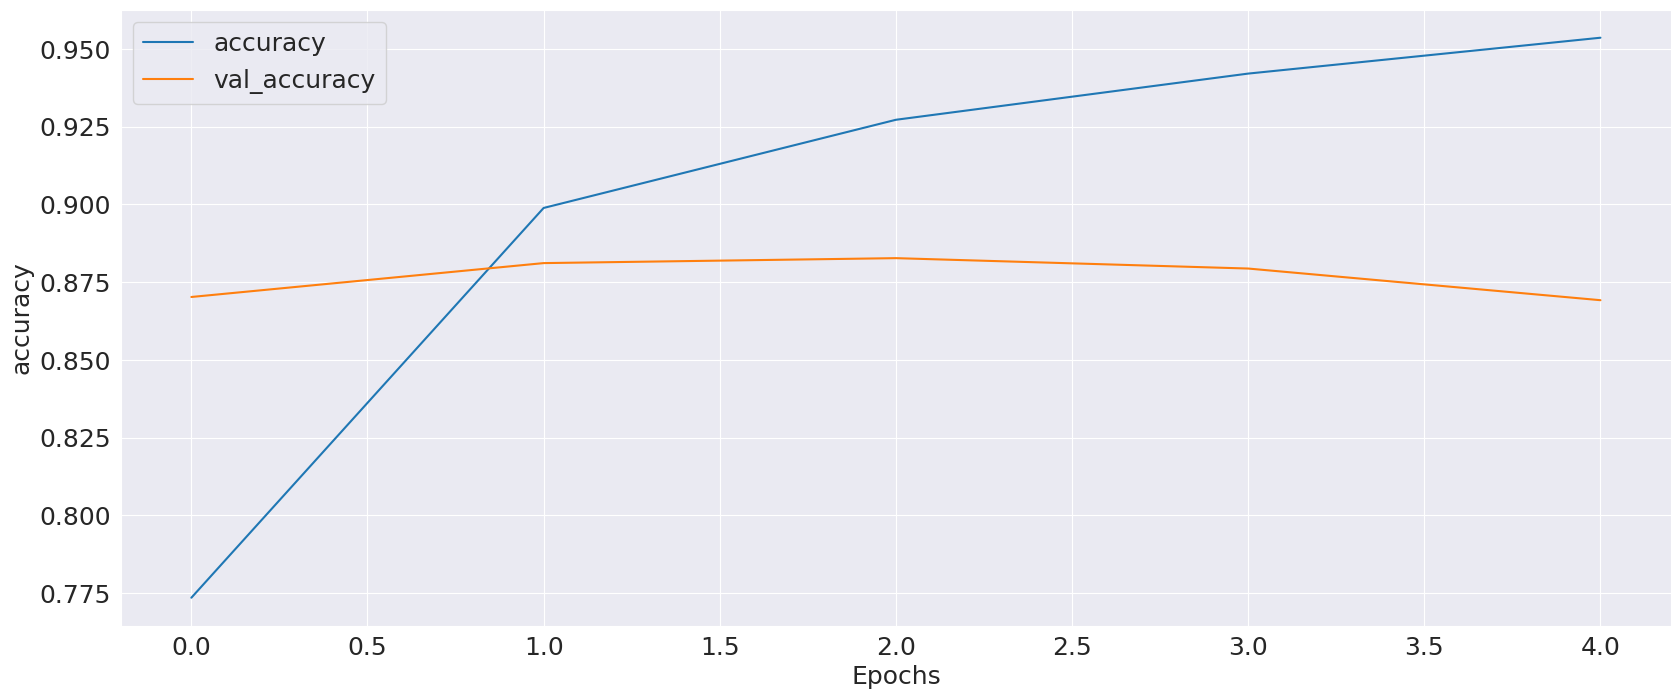

In [89]:
from utils.plot_utils import plot_history_metrics
plot_history_metrics(history, ['loss', 'accuracy'])

In [90]:
transformer_model.evaluate(test_data, test_label)

492/492 [==============================] - 2s 5ms/step - loss: 0.2995 - accuracy: 0.8867


[0.29948246479034424, 0.8867396116256714]

### Results
The model isn't generalizing all to good, which can be seen by the increasing validation loss, which is an indicator for overfitting. To combat this we could lower the vocabulary size, decrease sequence length or even try pre-trained embeddings like GloVe.